# Tutorial for the GAlib package

** Version 0.0**  (Updated: 07.07.2019)

This tutorial will guide you through the first steps towards using *GAlib*, a package to generate and analyse complex networks. First of all, we need is to load the libraries we will need to work. *GAlib* treats networks as adjacency matrices, represented as *NumPy* arrays.

In [1]:
# Imports from the Python standard library
from timeit import default_timer as timer
# Import 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

GAlib is in the Python Package Index (PyPI), therefore installation only requires to run the following command in a terminal 

    $ pip install galib

The following cell will check whether GAlib is already installed in the current working environment, otherwise, it will call `pip` for the installation (a working internet connection is required).

In [2]:
## Check if GAlib is installed in the current environment, otherwise install
try:
    import galib
except:
    print('Installing GAlib...')
    ! pip install galib
    import galib

<br/>
## 1. Structure of the library and getting information 

GAlib is organised into three main modules:

- *metrics.py*: Common graph metrics (degrees, clustering, graph distance, etc)
- *models.py*: Generation of synthetic networks and randomization.
- *tools.py*: Miscelaneous helper functions.

There are two modules to allocate copies of selected functions which run faster using *Numba*, an open source JIT compiler, tospeed up selected functions:

- *metrics_numba.py*: Uses the Numba package to accelerate calculation of some metrics.
- *models_numba.py*: Uses the Numba package to accelerate generation of some graph models.

The *extra* module contains functions related to network analysis but probably of interest for particular users only.

- *extra.py*: Additional measures and functionalities related to network analysis.

More detailed information is obtained calling the interactive help. To access the complete list of functions in each module, type:

In [7]:
# Import the main three modules (just needed once)
import galib.metrics
import galib.models
import galib.tools

In [10]:
galib.metrics?
#galib.models?
#galib.tools?

Detailed information for each function is found in the same manner:

In [13]:
# Uncomment different lines in this cell to see the help of the various functions
galib.Degree?
#galib.RichClub?
#galib.models.RandomGraph?
#galib.tools.LoadFromPajek?
#galib.tools.HammingDistance?

> **NOTE**: Importing galib imports also all functions in module *metrics.py* into the namespace. Therefore, in the previous cell we are calling `galib.Degree?` instead of `galib.metrics.Degree?` The rest of modules are imported separately.

<br>
## 2. Characterization of networks (*galib.metrics*)

For illustration, in this tutorial we will load a real network comprising the anatomical long-range brain connectivity in the brain of cats. The data consist of a parcellation (division) of one brain hemisphere into **53 cortical regions** (grey matter), and the anatomical long-range fibers experimentally identified between them. The original network is weighted and directed, we will symmetrise and binarise the network.

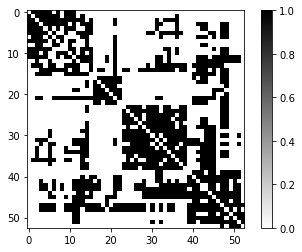

In [16]:
# Import the original network
dataroot = '../Examples/Data/'
net = loadtxt(dataroot + 'Cat53_cortex.txt', dtype=float)

# Binarise the directed network
dnet = np.where(net, 1, 0).astype(np.int)

# Symmetrise and binarise
unet = galib.tools.SymmetriseMatrix(net)
unet = np.where(unet, 1,0).astype(np.int)

# Finally, plot the adjacency matrix
figure()
plt.imshow(unet, cmap='gray_r')
plt.colorbar()

Since GAlib is based on NumPy, some basic functionalities only require NumPy operations, e.g., finding the number of nodes (N) and edges (L). 

In [18]:
# Fundamental properties of the network
N = len(unet)
L = 0.5 * unet.sum()
dens = galib.Density(unet)

print('Number of nodes, N: %d\t\tNumber of links, L: %d\t\tdensity: %1.3f' %(N, L, dens))

Number of nodes, N: 53		Number of links, L: 523		density: 0.380


Function `galib.Degree()` returns the degree of every node, but calculation of the degree distribution only requires, again, use of standard functions in either NumPy or Matplotlib.

Degrees: [ 9 12 20 22 17 23 17 11  9 18 15 27 22 28 32 19 11 12  7 11  8 28 11 14
 17 15 17 18 19 21 22 28 29 22 30 23 24 21 20 12 19 25 32 34 28 34 12 39
 37 11 14 16  4]
Min = 4, Max = 39, Mean degree: 19.736


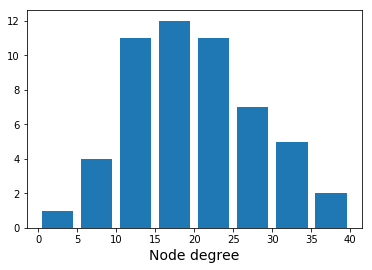

In [21]:
from galib import Degree

# Calculate the degree of every node
deg = Degree(unet, directed=False)
print( 'Degrees:', deg)
print('Min = %d, Max = %d, Mean degree: %1.3f' %(deg.min(), deg.max(), deg.mean()))

# Plot the degree distribution
plt.figure()
plt.hist(deg, bins=8, range=(0,40), rwidth=0.8) #, density=True)
plt.xlabel('Node degree', fontsize=14)

<br/>
<br/>
CONTINUE HERE !!!

In [12]:
from galib import Clustering

# Calculate the clustering of the network and the local clustering of every node
C, Cnodes = Clustering(netsym, checkdirected=False)

print( 'Clustering coefficient: %1.3f' %C )
print( 'Local clustering: Min = %1.3f, Max = %1.3f, Average = %1.3f' %(Cnodes.min(), Cnodes.max(), Cnodes.mean()) )

Clustering coefficient: 0.585
Local clustering: Min = 0.399, Max = 1.000, Average = 0.668


<br/>
### (Exercise 2) – Rich-club identification
We say a network has a rich when (i) there are hubs in a network and (ii) those hubs are densely interconnected. Rich-club identification is a two steps process:
1. Compute the $k$-density measure, $\Phi(k)$, and see whether it grows, stabilises or decays.
2. If $k$-density grows sufficiently, identify the set of hubs forming the rich-club.

**WARNING!** Unfortunately the identification of a rich-club implies some arbitrary choices. No strict criteria exist but, as a rule of thumb, if $\Phi(k)$ grows above 0.8, then you are pretty safe. Contrary to what is commonly found in the literature, the identification of a rich-club **does not** require the comparison to results from a null-model (random or rewired networks). Such comparisons are important, however, to inquiry about the *causes* leading to the presence (or the absence) of a rich-club.

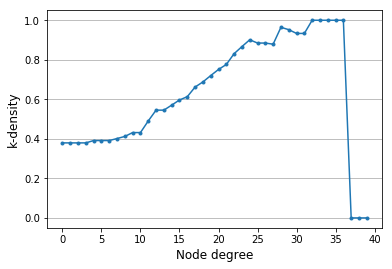

In [13]:
from galib import RichClub

# Compute the k-density and plot it
kdens = RichClub(netsym)
plt.figure()
plt.plot(kdens, '.-')
plt.xlabel('Node degree', fontsize=12)
plt.ylabel('k-density', fontsize=12)
plt.grid(axis='y')

In [15]:
# Identify the degree at which k-density overcomes the (arbitrary) threshold
densthres = 1.0
kthres = where(kdens >= densthres)[0][0]
# Identify the hubs forming the rich-club
richclub = where(deg >= kthres)[0]
print('Nodes in the richclub for k-density threshold %1.2f:' %densthres)
print(richclub)

Nodes in the richclub for k-density threshold 1.00:
[14 42 43 45 47 48]


In [16]:
# Let's now see who those rich-club regions are
from galib.tools import LoadLabels
labels = LoadLabels(dataroot + 'Areas53_list.txt')
for node in richclub:
    print(labels[node])

14	AES	Visual
42	Ia	Frontolimbic
43	Ig	Frontolimbic
45	CGp	Frontolimbic
47	35	Frontolimbic
48	36	Frontolimbic


<br/>
### (Exercise 3) – Global network properties 

1. Compute the diameter of the network and its average pathlength
2. Calculate the betwenness centrality of the nodes

The [Dijkstra algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) is a famous method to find the graph distance between two nodes in a graph. However, if we want to know the distance between all pairs, the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm) is faster than running Dijkstra N^2 times. 

In [17]:
from galib import FloydWarshall
# Calculate the pair-wise graph distance matrix
Dij = FloydWarshall(netsym)

diam = Dij.max()
avpathlen = (Dij.sum() - Dij.trace()) / (N*(N-1))

print('Diameter: %d\tAv. Pathlen: %1.3f' %(diam, avpathlen))

Diameter: 3	Av. Pathlen: 1.653


In [18]:
# Calculate the pairwise distance matrix, the between centrality of every node,
# all shortest paths from node i to j, and all shortest path starting 
# from i and returning to i
from galib import PathsAllinOne
Dij, bcnodes, paths, cycles = PathsAllinOne(netsym)
print( '\nBetweenness centrality. Min: %d\tMax: %d' %(bcnodes.min(), bcnodes.max()) )


Betweenness centrality. Min: 0	Max: 781


In [19]:
# Normalise BC of the nodes by the number of existing shortest paths
# diameter was diam=3
npaths = len(paths[1]) + len(paths[2]) + len(paths[3])
bcnormed = bcnodes / npaths 

print( 'Total number of shortest paths: %d' %npaths )
print( 'Betweenness centrality. Min: %1.3f\tMax: %1.3f' %(bcnormed.min(), bcnormed.max()) )

Total number of shortest paths: 13938
Betweenness centrality. Min: 0.000	Max: 0.056


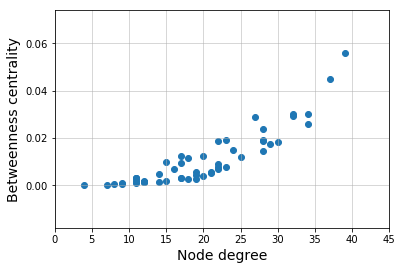

In [20]:
# Plot the relation between the degree and betweenness of each node
plt.figure()
plt.scatter(deg, bcnormed)
plt.xlabel('Node degree', fontsize=14)
plt.ylabel('Betweenness centrality', fontsize=14)
plt.xlim(0,45)
plt.grid(lw=0.5)

<br/>
### 2.X Directed networks

Most graph measures exist for directed networks, which provides richer information. Check for example the `Reciprocity()` and `ReciprocalDegree()` functions. GAlib functions usually come with an optional parameter `directed` in order to specify whether the undirected or the directed version of the metric is desired. By default, the parameter is set to `directed=False`.

For the rest of the tutorial we will consider that the long-range connectome is **symmetric**, which is a fairly good approximation, and we will ignore the weights of the links.

Show here Reciprocity, Degree, RichClub, Reciprocal degree ...

<br>
## 3. Network models and randomization (*galib.models*)



<br/>
### (Exercise 4) – Graph models. Null-models and benchmarks

We will now compare the properties of the cat connectome to the properties of typical reference networks: *random graphs* and *degree-preserving random graphs*. These comparisons serve us to explore where the properties observed in real connectome may come from.

**Random graphs** are the 1st-order reference network model. It is a well-known fact that the numerical outcome of all graph metrics strongly depends on how sparse, or how dense the network is (i.e., on the size N and number of links L.) This makes network comparison a difficult challenge. Random graphs are the network models with the least number of constraints (N and L) and only one assumption: that every link has been seeded independently, at random.

Beyond N and L, we often want to know how much do the observed metrics depend on a third constraint: the degree-distribution. Specially because the presence of hubs may strongly influence other properties. To explore that, we can generate reference graphs with the same N, L and degree-sequence as the original network, which are maximally random under those constraints. Because of the additional constraint, these are 2nd-order reference graphs. We can construct such networks by randomly rewiring the links of the original network, carefully conserving the given constraints.

In GAlib library, the functions to generate different network models are located in the *models.py* module.

In [21]:
# Generate ensemble of random graphs with same N and L as the cat connectome
from galib.models import RandomGraph
nrealiz = 10
randnets = zeros((nrealiz,N,N), uint8)
for re in range(nrealiz):
    randnets[re] = RandomGraph(N,L, directed=False)

In [22]:
# Generate ensemble of random graphs with same N and L and k-sequence as the cat connectome
from galib.models import RewireNetwork
rewnets = zeros((nrealiz,N,N), uint8)
for re in range(nrealiz):
    rewnets[re] = RewireNetwork(netsym, prewire=10, directed=False, weighted=False)

#### Compare the degree distributions

In [23]:
deglist_rand = []
deglist_rew = []
for re in range(nrealiz):
    deglist_rand += Degree(randnets[re], directed=False).tolist()
    deglist_rew += Degree(rewnets[re], directed=False).tolist()
deglist_rand = array(deglist_rand, dtype=uint)
deglist_rew = array(deglist_rew, dtype=uint)

print('\nDEGREES')
print('Cat \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deg.min(), deg.max(), deg.mean()))
print('Random \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deglist_rand.min(), deglist_rand.max(), deglist_rand.mean()) )
print('Rew \t Min = %d, Max = %d,\t Mean degree: %1.3f' %(deglist_rew.min(), deglist_rew.max(), deglist_rew.mean()))


DEGREES
Cat 	 Min = 4, Max = 39,	 Mean degree: 19.736
Random 	 Min = 10, Max = 32,	 Mean degree: 19.736
Rew 	 Min = 4, Max = 39,	 Mean degree: 19.736


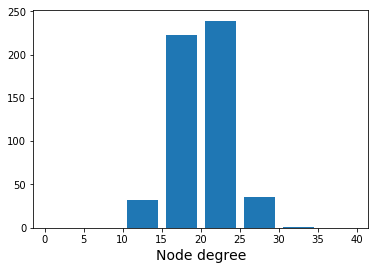

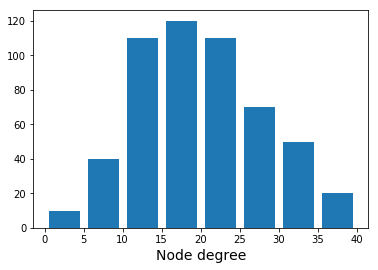

In [25]:
# Plot the degree distributions
plt.figure()
plt.hist(deglist_rand, bins=8, range=(0,40), rwidth=0.8) #, density=True)
plt.xlabel('Node degree', fontsize=14)

plt.figure()
plt.hist(deglist_rew, bins=8, range=(0,40), rwidth=0.8) #, density=True)
plt.xlabel('Node degree', fontsize=14)

#### Compare the clustering coefficient

In [26]:
Clist_rand = zeros(nrealiz, float)
Clist_rew = zeros(nrealiz, float)
for re in range(nrealiz):
    Crand, Cnodes_rand = Clustering(randnets[re])
    Clist_rand[re] = Crand
    Crew, Cnodes_rew = Clustering(rewnets[re])
    Clist_rew[re] = Crew

print('\nCLUSTERING COEFFICIENT')
print('Cat:\t%1.3f \nRandom:\t%1.3f \nRew:\t%1.3f' %(C, Crand, Crew))


CLUSTERING COEFFICIENT
Cat:	0.585 
Random:	0.366 
Rew:	0.473


#### Compare the pathlength and betweenness centrality

In [27]:
# First, calculate pathlengths and BC from the RANDOM graphs
avlenlist_rand = zeros(nrealiz, float)
bclist_rand = []
triuidx = triu_indices(N, k=1)
for re in range(nrealiz):
    Dij_rand, BC_rand, paths, cycles = PathsAllinOne(randnets[re])
    values = Dij_rand[triuidx]
    avlenlist_rand[re] = values.mean()
    bclist_rand += BC_rand.tolist()

# Calculate pathlengths and BC from the REWIRED graphs
avlenlist_rew = zeros(nrealiz, float)
bclist_rew = []
for re in range(nrealiz):
    Dij_rew, BC_rew, paths, cycles = PathsAllinOne(rewnets[re])
    values = Dij_rew[triuidx]
    avlenlist_rew[re] = values.mean()
    bclist_rew += BC_rew.tolist()


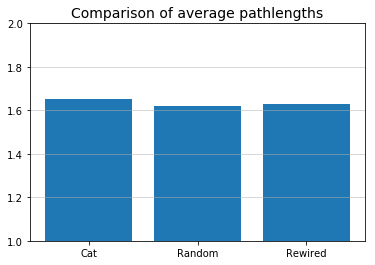

In [28]:
# Results for the average pathlength 
plt.figure()
plt.title('Comparison of average pathlengths', fontsize=14)
plt.bar( (1,2,3), (avpathlen, avlenlist_rand.mean(), avlenlist_rew.mean()) )
plt.ylim(1,2)
plt.xticks((1,2,3), ('Cat', 'Random', 'Rewired') )
plt.grid(axis='y', lw=0.5)


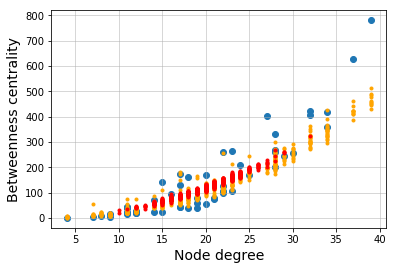

In [29]:
# Results for the betweenness centrality
plt.figure()
plt.scatter(deg, bcnodes)
plt.plot(deglist_rand, bclist_rand, '.', color='red', zorder=10)
plt.plot(deglist_rew, bclist_rew, '.', color='orange', zorder=5)
#plt.scatter(deg*deg, bcnodes)
#plt.plot(deglist_rand**2, bclist_rand, '.', color='red', zorder=10)
#plt.plot(deglist_rew**2, bclist_rew, '.', color='orange', zorder=5)

plt.xlabel('Node degree', fontsize=14)
plt.ylabel('Betweenness centrality', fontsize=14)
#plt.xlim(0,45)
plt.grid(lw=0.5)

# Try again with k**2. (comment'xlim' out). What happens?

<br/>
<br/>
## Functional Connectivity –––––––––––––––––––––––––––––––––––––––––––––––

Usually, functional connectivity is estimated from dynamic / statistic measures from the pairwise  temporal activities of two brain regions. Here, we don't have fMRI or EEG data from the brain of cats so, for illustration purposes, we will compute an analytical estimate (a prediction) of its FC (cross-correlation matrix). This estimate, *Topological similarity*, represents a diffusion process in the network. The details of the estimate are found in:

- Bettinardi, Deco et al. (2017) "*[How structure sculpts function: Unveiling the contribution of anatomical connectivity to the brain's spontaneous correlation structure](http://aip.scitation.org/doi/10.1063/1.4980099)*" Chaos, 27, 047409.

The estimate accepts a tunable parameter, a uniform coupling strength $g$ applied to all links.

In [30]:
# Import the function to estimate Topological Similarity
from galib.extra import TopologicalSimilarity

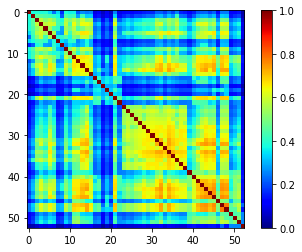

In [31]:
# Coupling strength
g = 0.09 #0.0766
fcnet = TopologicalSimilarity(netsym, g)

plt.figure()
plt.imshow(fcnet, cmap='jet')
plt.clim(0,1)
plt.colorbar()

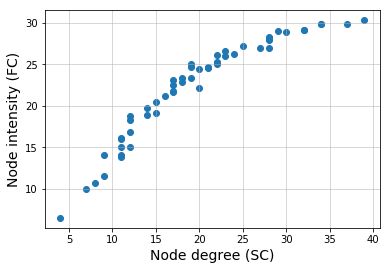

In [32]:
# Calculate the intensity of the nodes (weighted equivalent of degree)
from galib import Intensity
intens = Intensity(fcnet, directed=False)

# Compare SC degree and FC intensity
plt.figure()
plt.scatter(deg, intens)
plt.xlabel('Node degree (SC)', fontsize=14)
plt.ylabel('Node intensity (FC)', fontsize=14)
plt.grid(lw=0.5)

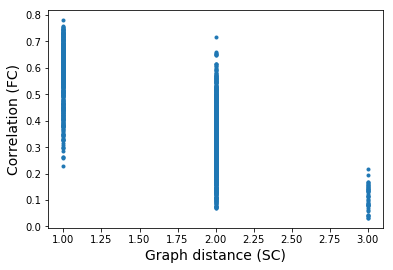

In [33]:
# Compare the graph distance and the pair-wise correlations
distvalues = Dij[triuidx]
fcvalues = fcnet[triuidx]
plt.figure()
plt.plot(distvalues, fcvalues, '.')
plt.xlabel('Graph distance (SC)', fontsize=14)
plt.ylabel('Correlation (FC)', fontsize=14)